<a href="https://colab.research.google.com/github/neuroidss/EEG-GAN-audio-video/blob/main/EEG_stream_connectivity_Generate_Abstraction%26Anime_Portraits_with_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''

/**/

//Joshua Brewster, GPL (copyleft)

//import 'regenerator-runtime/runtime' //For async functions on node\\

 class eeg32 { //Contains structs and necessary functions/API calls to analyze serial data for the FreeEEG32

    constructor(
		onDecodedCallback = this.onDecodedCallback,
		onConnectedCallback = this.onConnectedCallback,
		onDisconnectedCallback = this.onDisconnectedCallback,
		CustomDecoder = this.decode,
		baudrate = 115200
		) {

		this.onDecodedCallback = onDecodedCallback;
		this.onConnectedCallback = onConnectedCallback;
		this.onDisconnectedCallback = onDisconnectedCallback;
		this.decode = CustomDecoder;
		//Free EEG 32 data structure:
        
        //    [stop byte, start byte, counter byte, 32x3 channel data bytes (24 bit), 3x2 accelerometer data bytes, stop byte, start byte...] Gyroscope not enabled yet but would be printed after the accelerometer..
        //    Total = 105 bytes/line
        
		this.connected = false;
		this.subscribed = false;
        this.buffer = [];
        this.startByte = 160; // Start byte value
		this.stopByte = 192; // Stop byte value
		this.searchString = new Uint8Array([this.stopByte,this.startByte]); //Byte search string
		this.readRate = 16.666667; //Throttle EEG read speed. (1.953ms/sample min @103 bytes/line)
		this.readBufferSize = 2000; //Serial read buffer size, increase for slower read speeds (~1030bytes every 20ms) to keep up with the stream (or it will crash)

		this.sps = 512; // Sample rate
		this.nChannels = 32;
		this.nPeripheralChannels = 6; // accelerometer and gyroscope (2 bytes * 3 coordinates each)
		this.updateMs = 1000/this.sps; //even spacing
		this.stepSize = 1/Math.pow(2,24);
		this.vref = 2.50; //2.5V voltage ref +/- 250nV
		this.gain = 8;

		this.vscale = (this.vref/this.gain)*this.stepSize; //volts per step.
		this.uVperStep = 1000000 * ((this.vref/this.gain)*this.stepSize); //uV per step.
		this.scalar = 1/(1000000 / ((this.vref/this.gain)*this.stepSize)); //steps per uV.

		this.maxBufferedSamples = this.sps*60*2; //max samples in buffer this.sps*60*nMinutes = max minutes of data
		
		this.data = { //Data object to keep our head from exploding. Get current data with e.g. this.data.A0[this.data.count-1]
			count: 0,
			startms: 0,
			ms: [],
			'A0': [],'A1': [],'A2': [],'A3': [],'A4': [],'A5': [],'A6': [],'A7': [], //ADC 0
			'A8': [],'A9': [],'A10': [],'A11': [],'A12': [],'A13': [],'A14': [],'A15': [], //ADC 1
			'A16': [],'A17': [],'A18': [],'A19': [],'A20': [],'A21': [],'A22': [],'A23': [], //ADC 2
			'A24': [],'A25': [],'A26': [],'A27': [],'A28': [],'A29': [],'A30': [],'A31': [], //ADC 3
			'Ax': [], 'Ay': [], 'Az': [], 'Gx': [], 'Gy': [], 'Gz': []  //Peripheral data (accelerometer, gyroscope)
		};

		this.resetDataBuffers();

		//navigator.serial utils
		if(!navigator.serial){
			console.error("`navigator.serial not found! Enable #enable-experimental-web-platform-features in chrome://flags (search 'experimental')")
		}
		this.port = null;
		this.reader = null;
		this.baudrate = baudrate;

	}
	
	resetDataBuffers(){
		this.data.count = 0;
		this.data.startms = 0;
		for(const prop in this.data) {
			if(typeof this.data[prop] === "object"){
				this.data[prop] = new Array(this.maxBufferedSamples).fill(0);
			}
		}
	}

	setScalar(gain=24,stepSize=1/(Math.pow(2,23)-1),vref=4.50) {
        this.stepSize = stepSize;
		this.vref = vref; //2.5V voltage ref +/- 250nV
		this.gain = gain;

		this.vscale = (this.vref/this.gain)*this.stepSize; //volts per step.
		this.uVperStep = 1000000 * ((this.vref/this.gain)*this.stepSize); //uV per step.
		this.scalar = 1/(1000000 / ((this.vref/this.gain)*this.stepSize)); //steps per uV.
    }

	getLatestData(channel="A0",count=1) { //Return slice of specified size of the latest data from the specified channel
		let ct = count;
		if(ct <= 1) {
			return [this.data[channel][this.data.count-1]];
		}
		else {
			if(ct > this.data.count) {
				ct = this.data.count;
			}
			return this.data[channel].slice(this.data.count-ct,this.data.count);
		}
	}

    bytesToInt16(x0,x1){
		return x0 * 256 + x1;
    }

    int16ToBytes(y){ //Turns a 24 bit int into a 3 byte sequence
        return [y & 0xFF , (y >> 8) & 0xFF];
    }

    bytesToInt24(x0,x1,x2){ //Turns a 3 byte sequence into a 24 bit int
        return x0 * 65536 + x1 * 256 + x2;
    }

    int24ToBytes(y){ //Turns a 24 bit int into a 3 byte sequence
        return [y & 0xFF , (y >> 8) & 0xFF , (y >> 16) & 0xFF];
    }

    decode(buffer = this.buffer) { //returns true if successful, returns false if not

		var needle = this.searchString
		var haystack = buffer;
		var search = this.boyerMoore(needle);
		var skip = search.byteLength;
		var indices = [];
		let newLines = 0;

		for (var i = search(haystack); i !== -1; i = search(haystack, i + skip)) {
			indices.push(i);
		}
		//console.log(indices);
		if(indices.length >= 2){
			for(let k = 1; k < indices.length; k++) {
				if(indices[k] - indices[k-1] !== 105) {
					
				} //This is not a valid sequence going by size, drop sequence and return
				else {
					var line = buffer.slice(indices[k-1],indices[k]+1); //Splice out this line to be decoded
					
					// line[0] = stop byte, line[1] = start byte, line[2] = counter, line[3:99] = ADC data 32x3 bytes, line[100-104] = Accelerometer data 3x2 bytes

					//line found, decode.
					if(this.data.count < this.maxBufferedSamples){
						this.data.count++;
					}

					if(this.data.count-1 === 0) {this.data.ms[this.data.count-1]= Date.now(); this.data.startms = this.data.ms[0];}
					else {
						this.data.ms[this.data.count-1]=this.data.ms[this.data.count-2]+this.updateMs;
						
						if(this.data.count >= this.maxBufferedSamples) {
							this.data.ms.splice(0,5120);
							this.data.ms.push(new Array(5120).fill(0));
						}
					}//Assume no dropped samples
				
					for(var i = 3; i < 99; i+=3) {
						var channel = "A"+(i-3)/3;
						this.data[channel][this.data.count-1]=this.bytesToInt24(line[i],line[i+1],line[i+2]);
						if(this.data.count >= this.maxBufferedSamples) { 
							this.data[channel].splice(0,5120);
							this.data[channel].push(new Array(5120).fill(0));//shave off the last 10 seconds of data if buffer full (don't use shift())
						}
							//console.log(this.data[channel][this.data.count-1],indices[k], channel)
					}

					this.data["Ax"][this.data.count-1]=this.bytesToInt16(line[99],line[100]);
					this.data["Ay"][this.data.count-1]=this.bytesToInt16(line[101],line[102]);
					this.data["Az"][this.data.count-1]=this.bytesToInt16(line[103],line[104]);

					
					if(this.data.count >= this.maxBufferedSamples) { 
						this.data["Ax"].splice(0,5120);
						this.data["Ay"].splice(0,5120);
						this.data["Az"].splice(0,5120);
						this.data["Ax"].push(new Array(5120).fill(0))
						this.data["Ay"].push(new Array(5120).fill(0))
						this.data["Az"].push(new Array(5120).fill(0))
						this.data.count -= 5120;
					}
					//console.log(this.data)
					newLines++;
					//console.log(indices[k-1],indices[k])
					//console.log(buffer[indices[k-1],buffer[indices[k]]])
					//indices.shift();
				}
				
			}
			if(newLines > 0) buffer.splice(0,indices[indices.length-1]);
			return newLines;
			//Continue
		}
		//else {this.buffer = []; return false;}
	}

	//Callbacks
	onDecodedCallback(newLinesInt){
		console.log("new samples:", newLinesInt);
	}

	onConnectedCallback() {
		console.log("port connected!");
	}

	onDisconnectedCallback() {
		console.log("port disconnected!");
	}

	onReceive(value){
		this.buffer.push(...value);

		let newLines = this.decode(this.buffer);
		//console.log(this.data)
		//console.log("decoding... ", this.buffer.length)
		if(newLines !== false && newLines !== 0 && !isNaN(newLines) ) this.onDecodedCallback(newLines);
	}

	async onPortSelected(port,baud=this.baudrate) {
		try{
			try {
				await port.open({ baudRate: baud, bufferSize: this.readBufferSize });
				this.onConnectedCallback();
				this.connected = true;
				this.subscribed = true;
				this.subscribe(port);//this.subscribeSafe(port);
		
			} //API inconsistency in syntax between linux and windows
			catch {
				await port.open({ baudrate: baud, buffersize: this.readBufferSize });
				this.onConnectedCallback();
				this.connected = true;
				this.subscribed = true;
				this.subscribe(port);//this.subscribeSafe(port);
			}
		}
		catch(err){
			console.log(err);
			this.connected = false;
		}
	}

	async subscribe(port){
		if (this.port.readable && this.subscribed === true) {
			this.reader = port.readable.getReader();
			const streamData = async () => {
				try {
					const { value, done } = await this.reader.read();
					if (done || this.subscribed === false) {
						// Allow the serial port to be closed later.
						await this.reader.releaseLock();
						
					}
					if (value) {
						//console.log(value.length);
						try{
							this.onReceive(value);
						}
						catch (err) {console.log(err)}
						//console.log("new Read");
						//console.log(this.decoder.decode(value));
					}
					if(this.subscribed === true) {
						setTimeout(()=>{streamData();}, this.readRate);//Throttled read 1/512sps = 1.953ms/sample @ 103 bytes / line or 1030bytes every 20ms
					}
				} catch (error) {
					console.log(error);// TODO: Handle non-fatal read error.
                    if(error.message.includes('framing') || error.message.includes('overflow') || error.message.includes('Overflow') || error.message.includes('break')) {
                        this.subscribed = false;
                        setTimeout(async ()=>{
							try{
                            if (this.reader) {
                                await this.reader.releaseLock();
                                this.reader = null;
                            }
							} catch (er){ console.error(er);}
                            this.subscribed = true; 
                            this.subscribe(port);
                            //if that fails then close port and reopen it
                        },30); //try to resubscribe 
                    } else if (error.message.includes('parity') || error.message.includes('Parity') || error.message.includes('overrun') ) {
                        if(this.port){
                            this.subscribed = false;
                            setTimeout(async () => {
								try{
                                if (this.reader) {
                                    await this.reader.releaseLock();
                                    this.reader = null;
                                }
                                await port.close();
								} catch (er){ console.error(er);}
                                //this.port = null;
                                this.connected = false;
                                setTimeout(()=>{this.onPortSelected(this.port)},100); //close the port and reopen
                            }, 50);
                        }
                    }
                     else {
                        this.closePort();	
                    }	
				}
			}
			streamData();
		}
	}

	//Unfinished
	async subscribeSafe(port) { //Using promises instead of async/await to cure hangs when the serial update does not meet tick requirements
		var readable = new Promise((resolve,reject) => {
			while(this.port.readable && this.subscribed === true){
				this.reader = port.readable.getReader();
				var looper = true;
				var prom1 = new Promise((resolve,reject) => {
					return this.reader.read();
				});

				var prom2 = new Promise((resolve,reject) => {
					setTimeout(resolve,100,"readfail");
				});
				while(looper === true ) {
					//console.log("reading...");
					Promise.race([prom1,prom2]).then((result) => {
						console.log("newpromise")
						if(result === "readfail"){
							console.log(result);
						}
						else{
							const {value, done} = result;
							if(done === true || this.subscribed === true) { var donezo = new Promise((resolve,reject) => {
								resolve(this.reader.releaseLock())}).then(() => {
									looper = false;
									return;
								});
							}
							else{
								this.onReceive(value);
							}
						}
					});
				}
			}
			resolve("not readable");
		});
	}

	async closePort(port=this.port) {
		//if(this.reader) {this.reader.releaseLock();}
		if(this.port){
			this.subscribed = false;
			setTimeout(async () => {
				if (this.reader) {
					await this.reader.releaseLock();
					this.reader = null;
				}
				await port.close();
				this.port = null;
				this.connected = false;
				this.onDisconnectedCallback();
			}, 100);
		}
	}

	async setupSerialAsync(baudrate=this.baudrate) { //You can specify baudrate just in case

		const filters = [
			{ usbVendorId: 0x10c4, usbProductId: 0x0043 } //CP2102 filter (e.g. for UART via ESP32)
		];

		this.port = await navigator.serial.requestPort();
		navigator.serial.addEventListener("disconnect",(e) => {
			this.closePort(this.port);
		});
		this.onPortSelected(this.port,baudrate);

		//navigator.serial.addEventListener("onReceive", (e) => {console.log(e)});//this.onReceive(e));

	}


	//Boyer Moore fast byte search method copied from https://codereview.stackexchange.com/questions/20136/uint8array-indexof-method-that-allows-to-search-for-byte-sequences
	asUint8Array(input) {
		if (input instanceof Uint8Array) {
			return input;
		} else if (typeof(input) === 'string') {
			// This naive transform only supports ASCII patterns. UTF-8 support
			// not necessary for the intended use case here.
			var arr = new Uint8Array(input.length);
			for (var i = 0; i < input.length; i++) {
			var c = input.charCodeAt(i);
			if (c > 127) {
				throw new TypeError("Only ASCII patterns are supported");
			}
			arr[i] = c;
			}
			return arr;
		} else {
			// Assume that it's already something that can be coerced.
			return new Uint8Array(input);
		}
	}

	boyerMoore(patternBuffer) {
		// Implementation of Boyer-Moore substring search ported from page 772 of
		// Algorithms Fourth Edition (Sedgewick, Wayne)
		// http://algs4.cs.princeton.edu/53substring/BoyerMoore.java.html
		
//		USAGE:
			// needle should be ASCII string, ArrayBuffer, or Uint8Array
			// haystack should be an ArrayBuffer or Uint8Array
//			var search = boyerMoore(needle);
//			var skip = search.byteLength;
//			var indices = [];
//			for (var i = search(haystack); i !== -1; i = search(haystack, i + skip)) {
//				indices.push(i);
//			}
		
		var pattern = this.asUint8Array(patternBuffer);
		var M = pattern.length;
		if (M === 0) {
			throw new TypeError("patternBuffer must be at least 1 byte long");
		}
		// radix
		var R = 256;
		var rightmost_positions = new Int32Array(R);
		// position of the rightmost occurrence of the byte c in the pattern
		for (var c = 0; c < R; c++) {
			// -1 for bytes not in pattern
			rightmost_positions[c] = -1;
		}
		for (var j = 0; j < M; j++) {
			// rightmost position for bytes in pattern
			rightmost_positions[pattern[j]] = j;
		}
		var boyerMooreSearch = (txtBuffer, start, end) => {
			// Return offset of first match, -1 if no match.
			var txt = this.asUint8Array(txtBuffer);
			if (start === undefined) start = 0;
			if (end === undefined) end = txt.length;
			var pat = pattern;
			var right = rightmost_positions;
			var lastIndex = end - pat.length;
			var lastPatIndex = pat.length - 1;
			var skip;
			for (var i = start; i <= lastIndex; i += skip) {
				skip = 0;
				for (var j = lastPatIndex; j >= 0; j--) {
				var c = txt[i + j];
				if (pat[j] !== c) {
					skip = Math.max(1, j - right[c]);
					break;
				}
				}
				if (skip === 0) {
				return i;
				}
			}
			return -1;
		};
		boyerMooreSearch.byteLength = pattern.byteLength;
		return boyerMooreSearch;
	}
	//---------------------end copy/pasted solution------------------------

}

device = new eeg32();
//
//

    connect = async () => {
        await this.device.setupSerialAsync();
    }

    disconnect = () => {
        if (this.ui) this.ui.deleteNode()
        this.device.closePort();
    }


//this.connect();
//return eeg.data;

    async function takePhoto(quality) {

      const div = document.createElement('div');
      const capture1 = document.createElement('button');
      capture1.textContent = 'Capture1';
      div.appendChild(capture1);
      //capture1.onclick = 'navigator.serial.requestPort();';
      //capture1.onclick = function(event) {this.connect();};
      capture1.onclick = this.connect;
      //capture1.addEventListener("click", this.connect, false);

      //const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //await new Promise((resolve) => capture.onclick = resolve);
      await new Promise((resolve) => capture.onclick = resolve);

//this.connect();
    //device.port =  navigator.serial.requestPort();
		//navigator.serial.addEventListener("disconnect",(e) => {
		//	device.closePort(device.port);
		//});
		//device.onPortSelected(device.port,device.baudrate);

//var results = [];
//results.push(device.data.ms.slice(device.data.count-1-data_length,device.data.count-1);
//for(var i = 0; i < 32; i++){
//  var channel = "A"+i;
  //results.push(device.data[channel].slice(device.data.count-1-data_length,device.data.count-1);
//}

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();


      //return results;
      //return device.connected;
      data_length=5120;
      return [
        //device.data.ms.slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+0].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+1].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+2].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+3].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+4].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+5].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+6].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+7].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+8].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+9].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+10].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+11].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+12].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+13].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+14].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+15].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+16].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+17].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+18].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+19].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+20].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+21].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+22].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+23].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+24].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+25].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+26].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+27].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+28].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+29].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+30].slice(device.data.count-1-data_length,device.data.count-1),
        device.data["A"+31].slice(device.data.count-1-data_length,device.data.count-1)
        ];
      //return device.getLatestData();
      //return device.data;
      //return canvas.toDataURL('image/jpeg', quality);
    }

    ''')
  display(js)  
  data = eval_js('takePhoto({})'.format(quality))
  #binary = b64decode(data.split(',')[1])
  #data = eval_js('device.connected')
  #data = eval_js('device.connected')
  #data = eval_js('capture.click()')
  #data = eval_js('navigator.serial.requestPort()')
  

  #		this.connected = false;
	#	this.subscribed = false;
  #      this.buffer = [];
  #     this.startByte = 160; // Start byte value
	#	this.stopByte = 192; // Stop byte value
	#	this.searchString = new Uint8Array([this.stopByte,this.startByte]); //Byte search string
	#	this.readRate = 16.666667; //Throttle EEG read speed. (1.953ms/sample min @103 bytes/line)
	#	this.readBufferSize = 2000; //Serial read buffer size, increase for slower read speeds (~1030bytes every 20ms) to keep up with the stream (or it will crash)

  #		this.sps = 512; // Sample rate
	#	this.nChannels = 32;

  #data = eval_js('device.getLatestData()')
  #print(data)
  #binary = b64decode(data)
  #with open(filename, 'wb') as f:
  #  f.write(binary)
  #return filename
  return data

In [ ]:
from IPython.display import Image
try:
  data = take_photo()
  #print(data)
  
  # Show the image which was just taken.
  #display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [36]:
stepSize = 1/pow(2,24)
vref = 2.50 #2.5V voltage ref +/- 250nV
gain = 8

vscale = (vref/gain)*stepSize #volts per step.
uVperStep = 1000000 * ((vref/gain)*stepSize) #uV per step.
scalar = 1/(1000000 / ((vref/gain)*stepSize)) #steps per uV.
data_uv = [0]*32
for j in range(32):
  data_uv[j]=[0]*len(data[j])
  for i in range(len(data[j])):
    #data_uv[j][i] = data[j][i] / uVperStep  
    data_uv[j][i] = data[j][i] * uVperStep * 2
    #data_uv[j][i] = data[j][i] * uVperStep  
    #data_uv[j][i] = data[j][i] * scalar
    #data_uv[j][i] = data[j][i] * vscale
  print(data_uv[j][0])
#print(data_uv[0][0])

1251.99556350708
1361.742615699768
1549.6835112571716
1491.1964535713196
1248.4565377235413
1375.3026723861694
1391.582190990448
1387.96865940094
3335.4759216308594
3615.431487560272
3666.2817001342773
3836.6392254829407
3095.194697380066
3505.2746534347534
3661.6623401641846
4180.260002613068
5529.187619686127
5371.496081352234
5928.315222263336
5926.564335823059
4943.162202835083
5754.0833950042725
5899.630486965179
6880.909204483032
3363.30384016037
3586.0762000083923
3721.6395139694214
3817.1932101249695
3160.4990363121033
3399.290144443512
3722.459077835083
3861.1888885498047


In [3]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [4]:
print('Tensorflow version: {}'.format(tf.__version__) )

Tensorflow version: 1.15.2


In [5]:
#!git clone https://github.com/NVlabs/stylegan2.git
!git clone https://github.com/NVlabs/stylegan2-ada.git

Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.


In [6]:
%cd /content/stylegan2-ada

/content/stylegan2-ada


In [7]:
!pip install googledrivedownloader

In [8]:
#import pretrained_networks
from google_drive_downloader import GoogleDriveDownloader as gdd

#url = 'https://drive.google.com/open?id=1WNQELgHnaqMTq3TlrnDaVkyrAH8Zrjez'
#anime2:
#url = 'https://drive.google.com/open?id=1YckI8gwqPbZBI8X4eaQAJCgWx-CqCTdi'
#anime:
url = 'https://drive.google.com/open?id=1aUrChOhq5jDEddZK1v_Dp1vYNlHSBL9o'
#abstract:
#url = 'https://drive.google.com/open?id=1ie1vWw1JNsfrZWRtMvhteqzVz4mt4KGa'
#'https://drive.google.com/open?id=1BHeqOZ58WZ-vACR2MJkh1ZVbJK2B-Kle'
model_id = url.replace('https://drive.google.com/open?id=', '')

network_pkl = '/content/models/model_%s.pkl' % model_id#(hashlib.md5(model_id.encode()).hexdigest())
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path=network_pkl)
#_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

import pickle

import dnnlib
import dnnlib.tflib as tflib

tflib.init_tf()

with dnnlib.util.open_url(network_pkl) as fp:
        _G, _D, Gs = pickle.load(fp)


In [9]:
import numpy as np

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

In [10]:
!pip install tqdm

In [11]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.


In [12]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [13]:
#!mkdir /content/eeg
#!cp -r -v "/content/gdrive/MyDrive/EEG-GAN-audio-video/eeg/record-[2019.11.13-22.23.59].csv" "/content/eeg/"
#!cp -r -v "/content/gdrive/MyDrive/EEG-GAN-audio-video/eeg/record-[2020.06.28-14.26.09].csv" "/content/eeg/"

In [14]:
#from google_drive_downloader import GoogleDriveDownloader as gdd
!mkdir /content/eeg

#csv_name = 'record-[2020.06.28-14.26.09].csv'
#url = 'https://drive.google.com/open?id=1LtMfr9GduR3semMVgh_6JoUSKbCG8XbH'
#csv_name = 'record-[2019.11.13-22.23.59].csv'
#url = 'https://drive.google.com/open?id=1Nfzi6yT83SBZxtgIYVtYp7C7g_Sq9OdS'
#csv_id = url.replace('https://drive.google.com/open?id=', '')
#csv_path = '/content/eeg/%s' % csv_name
#gdd.download_file_from_google_drive(file_id=csv_id,
#                                    dest_path=csv_path)

#csv_name = 'record-[2019.11.13-22.23.59].csv'
#url = 'https://drive.google.com/open?id=1Nfzi6yT83SBZxtgIYVtYp7C7g_Sq9OdS'
#csv_id = url.replace('https://drive.google.com/open?id=', '')
#csv_path = '/content/eeg/%s' % csv_name
#gdd.download_file_from_google_drive(file_id=csv_id,
#                                    dest_path=csv_path)

In [15]:
!pip install mne


     |████████████████████████████████| 6.9 MB 3.7 MB/s 


In [16]:
import mne
from mne import io
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, compute_source_psd

from mne.connectivity import spectral_connectivity, seed_target_indices

import pandas as pd
import numpy as np


In [37]:
    key = 0
    idx = 0

    data_path = '/content/eeg'
    #raw_fname = data_path + '/record-[2019.11.13-22.23.59].gdf'
    #raw = mne.io.read_raw_gdf(raw_fname, preload=True)

    path = data_path

    ch_names = ['FP1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7','P3','Pz','PO3','O1','Oz','O2','PO4','P4','P8','CP6','CP2','C4','T8','FC6','FC2','F4','F8','AF4','FP2','Fz','Cz']
    #data = pd.read_csv(path + '/record-[2019.11.13-22.23.59].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    
    #ch_names = ['FP1','F3','P3','O1','O2','P4','F4','FP2']
    #data = pd.read_csv(path + '/record-[2020.06.28-14.26.09].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    
    #data = pd.read_csv(path + '/record-[2020.06.28-00.36.11].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    #data = pd.read_csv(path + '/record-[2020.06.29-19.49.23].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    
    #print(data)
    #data_transpose=np.transpose(data)

    sfreq = 512 
    ch_types=['eeg']*len(ch_names)
    info = mne.create_info(ch_names = ch_names, sfreq = sfreq, ch_types=ch_types)
    #info = mne.create_info(sfreq = sfreq)
    #raw = mne.io.RawArray(data_transpose, info)
    raw = mne.io.RawArray(data_uv, info)
    #raw = mne.io.RawArray(data, info)
    #raw.plot()

    # Setup for reading the raw data
    #raw = io.read_raw_fif(raw_fname, verbose=False)
    #events = mne.find_events(raw, stim_channel='STI 014')
    #inverse_operator = read_inverse_operator(fname_inv)
    #raw.info['bads'] = ['MEG 2443', 'EEG 053']

    # picks MEG gradiometers
    #picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False)
    picks = ch_names

Creating RawArray with float64 data, n_channels=32, n_times=5120
    Range : 0 ... 5119 =      0.000 ...     9.998 secs
Ready.


In [18]:
#!pip install imageio==2.9
!pip install imageio==2.4.1
!pip install imageio-ffmpeg==0.4.3 pyspng==0.1.0

     |████████████████████████████████| 26.9 MB 84 kB/s 
     |████████████████████████████████| 195 kB 50.1 MB/s 


In [19]:
!mkdir '/content/out'

In [20]:
import imageio
fps=10
out = imageio.get_writer('/content/out/output.mp4', mode='I', fps=fps, codec='libx264', bitrate='16M')
#for img in imgs:
#  out.append_data(np.asarray(img))
#out.close()
            

In [21]:
#for ch in ch_names:
#  raw.set_channel_types({ch:'eeg'})
#raw.crop(tmax=150)
#raw.crop(tmax=150).resample(100).pick('eeg')



In [38]:
bands = [[8.,12.]]
#bands = [[4.,7.],[8.,12.],[13.,29.]]
#bands = [[8.,12.],[8.,12.],[8.,12.]]
#bands_name = ['theta','alpha','beta']
datas=[]
for band in range(len(bands)):
 datas.append(raw)
# datas.append(raw.filter(l_freq=bands[band][0], h_freq=bands[band][1],method='iir'))
#theta_data = raw.filter(l_freq=4, h_freq=7,method='iir')
#alpha_data = raw.filter(l_freq=8, h_freq=12,method='iir')
#beta_data = raw.filter(l_freq=13, h_freq=29,method='iir')

In [39]:
methods = ['coh']
#methods = ['ciplv']
#methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'wpli']
epochs = []
for band in range(len(bands)):
# epochs.append(mne.make_fixed_length_epochs(datas[band], 
#                                            duration=0.1, preload=False))
 epochs.append(mne.make_fixed_length_epochs(datas[band], 
                                            duration=5*1/8, preload=False, overlap=5*1/8-0.1))
# epochs.append(mne.make_fixed_length_epochs(datas[band], duration=1.25, preload=False, overlap=1.15))
#epochs = [mne.make_fixed_length_epochs(theta_data, duration=0.1, preload=False),
#          mne.make_fixed_length_epochs(alpha_data, duration=0.1, preload=False),
#          mne.make_fixed_length_epochs(beta_data, duration=0.1, preload=False)]
#epochs = mne.make_fixed_length_epochs(alpha_data, duration=0.1, preload=False)
#epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=True)
#epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True)
#epochs = mne.make_fixed_length_epochs(raw, duration=1, preload=False)
#event_related_plot = epochs.plot_image(picks=['FP1'])


Not setting metadata
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated


import matplotlib.pyplot as plt

corr_matrix = mne.connectivity.envelope_correlation(alpha_data, combine=None)

first_30 = corr_matrix[0]
last_30 = corr_matrix[-1]
corr_matrices = [first_30, last_30]
color_lims = np.percentile(np.array(corr_matrices), [5, 95])
titles = ['First 30 Seconds', 'Last 30 Seconds']

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Correlation Matrices from First 30 Seconds and Last 30 Seconds')
for ci, corr_matrix in enumerate(corr_matrices):
    ax = axes[ci]
    mpbl = ax.imshow(corr_matrix, clim=color_lims)
    ax.set_xlabel(titles[ci])
fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.2, 0.025, 0.6])
cbar = fig.colorbar(ax.images[0], cax=cax)
cbar.set_label('Correlation Coefficient')

In [43]:
#fmin=8.
#fmax=13.
fmin=bands[0][0]
fmax=bands[0][1]+1.
          
sfreq = raw.info['sfreq']  # the sampling frequency
#con_methods = ['coh', 'pli', 'ciplv']
con_methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'wpli']
#con_methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli', 'wpli2_debiased']
#con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
#    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=10)
#con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs[1][2000:2010], method=con_methods, mode='multitaper', sfreq=sfreq, 
#    faverage=True, mt_adaptive=True, n_jobs=1)
#con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs[0][2000,2001], method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
#    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
#con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs[0][2000:2010], method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
#    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    epochs[0][0:10], method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 496 connections
    using t=0.000s..0.623s for estimation (320 points)
    frequencies: 8.0Hz..12.8Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, ciPLV, PPC, PLI, WPLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]


In [44]:
#freqs1= [[4.,7.],[8.,13.],[14.,30.]]

In [45]:
#for freq, ii in freqs1:
# sfreq = raw.info['sfreq']  # the sampling frequency
# con_methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'wpli']
# #con_methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli', 'wpli2_debiased']
# con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=freq[0],
#    fmax=freq[1], faverage=True, mt_adaptive=True, n_jobs=10)


In [46]:
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c[:, :, 0]

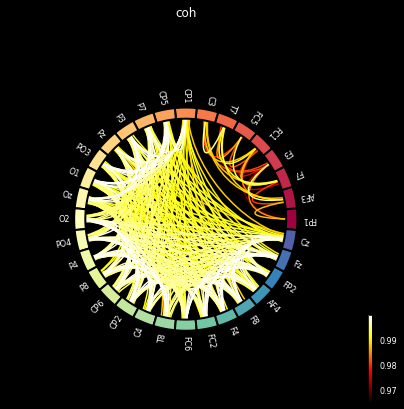

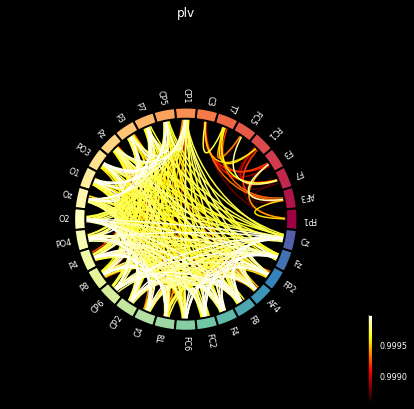

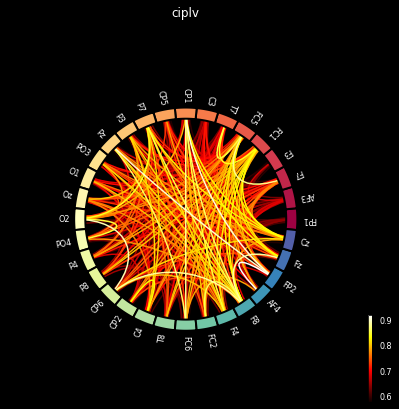

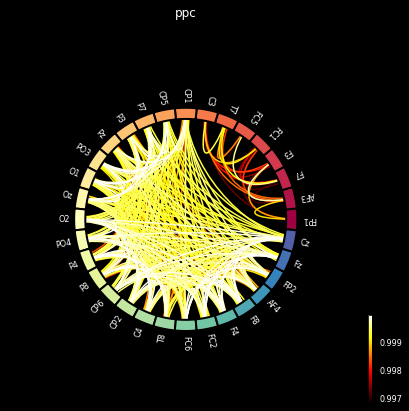

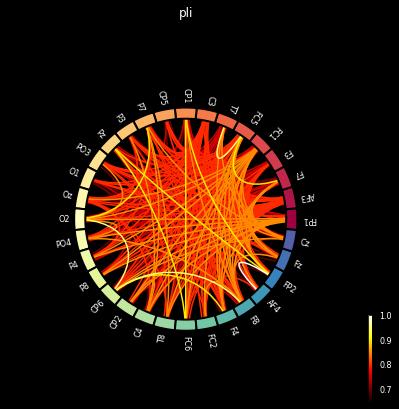

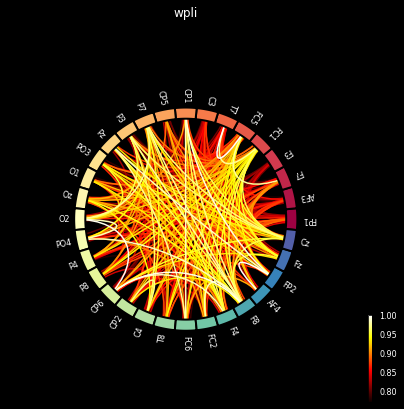

In [47]:
from mne.viz import circular_layout, plot_connectivity_circle
import matplotlib.pyplot as plt

label_names = ch_names

#plot_connectivity_circle(con_res['pli'], label_names, 
#                                                  title='All-to-All Connectivity (PLI)')
#fig = plt.figure(num=None, figsize=(8, 4), facecolor='black')
no_names = [''] * len(label_names)
for ii, method in enumerate(con_methods):
    plot_connectivity_circle(con_res[method], label_names, n_lines=300,
                             title=method)
    #plot_connectivity_circle(con_res[method], label_names, n_lines=300,
    #                         title=method, padding=0, fontsize_colorbar=6,
    #                         fig=fig, subplot=(1, 8, ii + 1))

    #plot_connectivity_circle(con_res[method], no_names, n_lines=300,
    #                         title=method, padding=0, fontsize_colorbar=6,
    #                         fig=fig, subplot=(1, 6, ii + 1))
plt.show()

In [48]:
con_res['coh']

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.98755864, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.9500211 , 0.98085693, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.50397875, 0.57291167, 0.66718756, ..., 0.        , 0.        ,
        0.        ],
       [0.51169365, 0.58055052, 0.67396198, ..., 0.99903998, 0.        ,
        0.        ],
       [0.51951479, 0.5874673 , 0.67874682, ..., 0.99805456, 0.99936157,
        0.        ]])

In [49]:
#from mne.viz import plot_sensors_connectivity
#plot_sensors_connectivity(epochs.info, con[:, :, 0])

In [50]:
#from mne.time_frequency import AverageTFR
#tfr = AverageTFR(epochs.info, con, times, freqs, len(epochs))
#tfr.plot_topo(fig_facecolor='w', font_color='k', border='k')

In [51]:
#import logging
#logging.basicConfig(level='warning')


In [52]:
# Generate random breaks and display audio

# CHANGE THIS to change number of examples generated
#n_generate = 30
#n_generate = 150
#n_generate = 300
#n_generate = 305
#n_generate = 390

# Sample latent vectors
#seed = 666 # change this seed to generate different set of breaks
#np.random.seed(seed)
#_z = (np.random.rand(n_generate, dim) * 2.) - 1.


hz=44100
#hz=39936
#hz=int(32768*2*(600/240))
#hz=int(32768*2*(480/240))
#hz=int(32768*2*(360/240))
#hz=int(32768*2*(300/240))
#hz=int(32768*2*(265/240))
#hz=int(32768*2*(250/240))
#hz=int(32768*2*(240/240)*1.6666666)
#hz=int(32768*2*(240/240))
#hz=int(32768*2*(120/240))
#fps=hz/(32768*2)
#fps=10
#fps=0.5
#fps=44100/(32768*2)
#fps=1
#fps=1/3
#fps=1.5

#n_generate=int((307-2)*fps)
#n_generate=int((160-2)*fps)
#n_generate=int((1598-2)*fps)
n_generate=int((1648-2)*fps)
#n_generate=int((10-2)*fps)
#n_generate=int((1607-2)*fps)
#n_generate=150
part_len = 10
#part_len = 275
dim = 512


n_parts = n_generate//part_len
if n_generate%part_len>0:
    n_parts=n_parts+1

vol=0.1

psd_array=np.random.rand(part_len, dim) 

#out = imageio.get_writer('./output.mp4', mode='I', fps=fps, codec='libx264', bitrate='16M')

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False

imgs = []
imgs1 = []


#z_avg_samples=n_generate
#for i in range(n_generate): # display separate audio for each break
for j in range(n_parts): # display separate audio for each break
    for i in range(part_len): # display separate audio for each break
        ji = j * part_len + i
        
        if (i==0) and (n_generate-ji<part_len):
            psd_array=np.random.rand((n_generate-ji), dim) 


        eeg_step=ji
        #print (f'EEG step: {(eeg_step/3):.1f} s')
        tmin, tmax = 0+(eeg_step/fps), 2+(eeg_step/fps)  # use the first 120s of data
        #tmin, tmax = 0+(10*eeg_step/512), 2+(10*eeg_step/512)  # use the first 120s of data
        fmin, fmax = 0.5, 256  # look at frequencies between 4 and 100Hz
        #fmin, fmax = 0.5, 50  # look at frequencies between 4 and 100Hz
        #fmin, fmax = 8, 12  # look at frequencies between 4 and 100Hz
        #n_fft = 512  # the FFT size (n_fft). Ideally a power of 2
        n_fft = 1024  # the FFT size (n_fft). Ideally a power of 2
        #n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2
        #label = mne.read_label(fname_label)
        
        print(str(ji) + '/' + str(n_generate))
        #logger = logging.getLogger()
        #logger.disabled = True

        sfreq = raw.info['sfreq']  # the sampling frequency
        
        psds=np.zeros(dim)
        
        for method in range(len(methods)):
         for band in range(len(bands)):
          #fmin=8.
          #fmax=13.
          fmin=bands[band][0]
          fmax=bands[band][1]
          if band == 0:
           con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
            epochs[band][ji:ji+10], method=methods[method], mode='multitaper', sfreq=sfreq, fmin=fmin,
            fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
          #con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
          #  epochs[band][ji,ji+1], method=methods[method], mode='multitaper', sfreq=sfreq, fmin=fmin,
          #  fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
          psds_shift1=int(round(method*len(bands)+band)*(len(ch_names)*(len(ch_names)-1)/2))
          ji1=0
          for j1 in range(0,len(ch_names)): # display separate audio for each break
            for i1 in range(0,j1): # display separate audio for each break
              psds[ji1+psds_shift1]=(con[j1][i1][0]-0.5)*1
              ji1 = ji1+1
        #psds, freqs = mne.time_frequency.psd_welch(raw, picks=picks,
        #                 tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax,
        #                 n_fft=n_fft)
        #logger.disabled = False

        #print(freqs)
        #print(psds)
        
        psd_array[i]=psds
        ##z_samples = psds

        #w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
        #w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
        ##z_avg = np.mean(z_samples, axis=0)      # [1, 1, C]
        #z_avg = np.mean(z_samples, axis=0, keepdims=True)      # [1, 1, C]
        ##psd_array[i]=z_avg
        #psd_array[i]=z_avg
        #print(z_avg)
        #z_std = (np.sum((z_samples - z_avg) ** 2) / z_avg_samples) ** 0.5

        #psd_array[i]=psds
        #psds_transpose=np.transpose(psds)
        #plt.plot(freqs,psds_transpose)
        #plt.xlabel('Frequency (Hz)')
        #plt.ylabel('PSD (dB)')
        #plt.title('Power Spectrum (PSD)')
        #plt.show()
        if (i==part_len-1) or (ji==n_generate-1) :
            
            _z = psd_array * vol
            images = Gs.run(_z, None, **Gs_kwargs) # [minibatch, height, width, channel]
            for image in images:
              #imgs1.append(image)
              out.append_data(np.asarray(PIL.Image.fromarray(image, 'RGB')))

              #imgs.append(PIL.Image.fromarray(image, 'RGB'))
            #out.append(PIL.Image.fromarray(images[0], 'RGB'))
            #_G_z = sess.run(G_z, {z: _z})[:,:,0]
            #if j==0:
            #    _G_z_full=_G_z
            #else:
            #    _G_z_full=np.append(_G_z_full,_G_z)
            if (ji==n_generate-1) :
                break

#print(psd_array)
#print(psd_array.shape)
#print(psd_array.ndim)
#_z = psd_array / 5.
#_z = psd_array / 10.
#_z = (psd_array * 2.) - 1.
#_G_z = sess.run(G_z, {z: _z})[:,:,0]

# display(Audio(_G_z.flatten(), rate=39936)) # display all in one audio

#for i in range(n_generate): # display separate audio for each break
  #print(i)
  #display(Audio(np.tile(_G_z[i][1:_G_z[i].ndim/2], 2), rate=39936)) # change rate for different tempo
  #display(Audio(np.tile(_G_z[i][1:32768], 2), rate=32768)) # change rate for different tempo
  #display(Audio(np.tile(_G_z[i], 1), rate=32768)) # change rate for different tempo
#out.close()


0/16460
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 496 connections
    using t=0.000s..0.623s for estimation (320 points)
    frequencies: 8.0Hz..11.2Hz (3 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
1/16460
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 496 connections
    using t=0.0

UnboundLocalError: ignored

In [ ]:
#con

In [53]:
out.close()

In [54]:
from google.colab import files
files.download('/content/out/output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#stop

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!cp -r -v "/content/out" "/content/gdrive/MyDrive/EEG-GAN-audio-video"

In [ ]:
stop

In [ ]:
min(np.random.randn(10000000))

In [ ]:
max(np.random.randn(10000000))

In [ ]:
imageio.plugins.ffmpeg.download()


In [ ]:
import moviepy.editor
duration_sec=n_generate/fps

def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, n_generate - 1))
    #latents = all_latents[frame_idx]
    return imgs1[frame_idx]

video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

video_clip.write_gif('/content/out/output.gif',fps=fps)



In [ ]:
!cp -r -v "/content/out" "/content/gdrive/MyDrive/EEG-GAN-audio-video"


In [ ]:
fps = 15
codec = 'libx264'
bitrate = '2M'#4M
random_seed = np.random.randint(0, 999)#405
filename = 'random_grid_%s.gif' % random_seed
truncation_psi= 0.7

#import moviepy.editor
#video_clip = moviepy.editor.VideoClip(imgs, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

#video_clip.write_gif(filename,fps=15)

In [ ]:
# generate some random seeds
seeds = np.random.randint(10000000, size=9)
print(seeds)

zs = generate_zs_from_seeds(seeds)
imgs = generate_images(zs, .7)

In [ ]:
imgs[0]

In [ ]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

In [ ]:
createImageGrid(imgs, rows=3)

In [ ]:
def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)
createImageGrid(imgs, rows=1)

In [ ]:
import scipy

grid_size = [3, 3]
image_shrink = 1
image_zoom = 1
duration_sec = 5
smoothing_sec = 1.0
fps = 15
codec = 'libx264'
bitrate = '2M'#4M
random_seed = np.random.randint(0, 999)#405
filename = 'random_grid_%s.gif' % random_seed
truncation_psi= 0.7

num_frames = int(np.rint(duration_sec * fps))
random_state = np.random.RandomState(random_seed)

# Generate latent vectors
shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * fps] + [0] * len(Gs.input_shape), mode='wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))


def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# Frame generation func for moviepy.
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=truncation_psi,
                          randomize_noise=False, output_transform=fmt, 
                          minibatch_size=16)

    grid = create_image_grid(images, grid_size)
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

# Generate video.
import moviepy.editor
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

video_clip.write_gif(filename,fps=15)

In [ ]:
#video_clip.write_videofile("interpolate.mp4", fps=15, codec='libx264', bitrate='2M')
video_clip.write_gif(filename,fps=15)

In [ ]:
from IPython import display as ipythondisplay
import io
import os
import base64
from IPython.display import HTML

def show_video(vid):
  #mp4list = [video
  #if len(mp4list) > 0:
  ext = os.path.splitext(vid)[-1][1:]
  video = io.open(vid, 'r+b').read()
  #encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
              loop controls style="height: 400px;">
              <source src="data:video/{1}';base64,{0}" type="video/{1}" />
              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))
  
show_video(filename)